In [161]:
import tensorflow as tf
from keras import layers, models
import numpy as np
import cv2
import os
from skimage import io, color
import os
import matplotlib.pyplot as plt
import random
from skimage import transform
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

from keras.applications import VGG19
from keras.models import Model

In [167]:
from pathlib import Path

data_dir = 'coco_dataset/VAL'

image_size = (256, 256)
batch_size = 5

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(grayscale.shape, image.shape)
    return grayscale/255.0, image/255.0
def preprocess_with_mask(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(image.shape)
    height, width = image.shape[1], image.shape[2]

    # Create a binary mask with 1% of pixels randomly set to 1
    num_pixels = height * width
    num_hints = int(0.01 * num_pixels) 
    flat_indices = tf.random.shuffle(tf.range(num_pixels))[:num_hints]
    binary_mask = tf.scatter_nd(
        indices=tf.expand_dims(flat_indices, axis=1),
        updates=tf.ones_like(flat_indices, dtype=tf.float32),
        shape=(num_pixels,)
    )
    binary_mask = tf.reshape(binary_mask, (height, width))  # Reshape to 2D

    # Expand binary mask to 3 channels and apply it to the original image
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    color_mask = image * tf.cast(binary_mask, dtype=image.dtype)

    grayscale = grayscale / 255.0
    color_mask = color_mask / 255.0
    image = image / 255.0
    return (grayscale, color_mask), image


# from skimage.color import rgb2lab, lab2lch
import tensorflow_io
from tensorflow_io.python.experimental.color_ops import rgb_to_lab
def preprocess_lab(image):

    image = tf.cast(image/255, tf.float32)
    lab = rgb_to_lab(image)
    l = lab[...,0]/100.0
    a = ( lab[...,1] + 128.0) /256.0
    b = ( lab[...,2] + 128.0) /256.0
    l = tf.expand_dims(l, axis=-1)
    a = tf.expand_dims(a, axis=-1)
    b = tf.expand_dims(b, axis=-1)
    ab = tf.concat([a,b], axis=-1)
    print(l.shape, ab.shape)
    return l, ab,l





Found 5 files.


In [168]:
val_dataset = dataset.map(preprocess_for_colorization, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)


(None, 256, 256, 1) (None, 256, 256, 3)


In [164]:
def psnr(y_true, y_pred):
    max_pixel = 1.0  
    # print(y_true.shape, y_pred.shape)
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def ssim(y_true, y_pred):
    max_pixel = 1.0  
    return tf.image.ssim(y_true, y_pred, max_val=max_pixel)

def evaluate_model_on_validation(model, val_data):
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    mae_scores = []

    # Initialize the MSE and MAE loss functions
    mse_loss_fn = tf.keras.losses.MeanSquaredError()
    mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

    # Iterate over the validation dataset
    for grayscale_batch, rgb_batch in val_data:
        predicted_batch = model.predict(grayscale_batch)

        # Iterate through each image in the batch
        for i in range(grayscale_batch.shape[0]):  
            true_image = rgb_batch[i]
            pred_image = np.clip(predicted_batch[i], 0, 1)  # Ensure predictions are in [0, 1]

            # Calculate PSNR and SSIM
            psnr_score = psnr(true_image, pred_image)  
            ssim_score = ssim(true_image, pred_image)  
            
            # Calculate MSE and MAE
            mse_score = mse_loss_fn(true_image, pred_image).numpy()
            mae_score = mae_loss_fn(true_image, pred_image).numpy()

            # Append the calculated values to their respective lists
            psnr_scores.append(psnr_score.numpy())  
            ssim_scores.append(ssim_score.numpy())  
            mse_scores.append(mse_score)  
            mae_scores.append(mae_score)

    # Calculate mean values for all metrics
    mean_psnr = np.mean(psnr_scores)
    mean_ssim = np.mean(ssim_scores)
    mean_mse = np.mean(mse_scores)
    mean_mae = np.mean(mae_scores)

    # Print the average scores
    print(f"Mean PSNR: {mean_psnr:.2f} dB")
    print(f"Mean SSIM: {mean_ssim:.4f}")
    print(f"Mean MSE: {mean_mse:.6f}")
    print(f"Mean MAE: {mean_mae:.6f}")

    return mean_psnr, mean_ssim, mean_mse, mean_mae

In [5]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Flatten, Dense, RepeatVector, Reshape, Lambda
from tensorflow.keras.applications import VGG16

input_shape = (256,256,1)


def create_lab_colorization_model_with_vgg_features():
    input_l = Input(shape=(input_shape[0], input_shape[1], 1), name="Input_L")
    input_l_rgb = Lambda(lambda x: tf.image.grayscale_to_rgb(x), name="Pseudo_RGB")(input_l)

    # Extract features from VGG16
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))
    vgg_extractor = Model(vgg_model.input, vgg_model.layers[-6].output)  
    vgg_features = vgg_extractor(input_l_rgb)  

    # Process global features with additional layers
    global_features = Conv2D(512, (3, 3), padding='same', strides=(2, 2), activation='relu')(vgg_features)
    global_features = BatchNormalization()(global_features)
    global_features = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(global_features)
    global_features = BatchNormalization()(global_features)
    global_features = UpSampling2D((2, 2))(global_features)

    # Encoder (downsampling) with skip connections
    x1 = Conv2D(64, (3, 3), activation="relu", padding="same", strides=1)(input_l)
    x1 = BatchNormalization()(x1)
    x2 = Conv2D(128, (3, 3), activation="relu", padding="same", strides=2)(x1)  
    x2 = BatchNormalization()(x2)
    x3 = Conv2D(256, (3, 3), activation="relu", padding="same", strides=2)(x2)  
    x3 = BatchNormalization()(x3)
    x4 = Conv2D(512, (3, 3), activation="relu", padding="same", strides=2)(x3)  
    x4 = BatchNormalization()(x4)

    # Merge global features into the decoder
    x4 = Concatenate()([x4, global_features])
    x4 = BatchNormalization()(x4)

    # Decoder (upsampling) with skip connections
    x5 = UpSampling2D((2, 2))(x4)  # Upsampling
    x5 = Concatenate()([x5, x3])  # Skip connection
    x5 = Conv2D(256, (3, 3), activation="relu", padding="same")(x5)
    x5 = BatchNormalization()(x5)

    x6 = UpSampling2D((2, 2))(x5)  # Upsampling
    x6 = Concatenate()([x6, x2])  # Skip connection
    x6 = Conv2D(128, (3, 3), activation="relu", padding="same")(x6)
    x6 = BatchNormalization()(x6)

    x7 = UpSampling2D((2, 2))(x6)  # Upsampling
    x7 = Concatenate()([x7, x1])  # Skip connection
    x7 = Conv2D(64, (3, 3), activation="relu", padding="same")(x7)
    x7 = BatchNormalization()(x7)

    # Final output layer for ab channels
    ab_output = Conv2D(2, (1, 1), activation="sigmoid", name="Output_ab")(x7)

    # Combine inputs and outputs into the final model
    model = Model(inputs=input_l, outputs=[ab_output], name="Lab_Colorization_Model_With_VGG_Features")

    return model





In [113]:
def psnr(y_true, y_pred):
    max_pixel = 1.0  
    # print(y_true.shape, y_pred.shape)
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

def ssim(y_true, y_pred):
    max_pixel = 1.0  
    return tf.image.ssim(y_true, y_pred, max_val=max_pixel)
import json
def save_loss(history, path):
    with open(path + ".json", 'w') as f:
        json.dump(history.history, f)


vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False  

feature_extractor = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv2').output)
def perceptual_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(feature_extractor(y_true) - feature_extractor(y_pred)))
    return loss


In [7]:
# del rgb_model_mse, lab_model_mse, lab_model_vgg, models_rgb,models_lab

In [169]:


custom_objects = {
    "psnr": psnr,
    "ssim": ssim,
}
rgb_model_perceptual = load_model("rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark.keras", 
                                  custom_objects = {    "psnr": psnr,
                                                        "ssim": ssim,
                                                        "perceptual_loss" : perceptual_loss

})


In [115]:
m_psnr, m_ssim = evaluate_model_on_validation(rgb_model_perceptual, val_dataset) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Mean PSNR: 18.46 dB
Mean SSIM: 0.5724
Mean MSE: 0.015657
Mean MAE: 0.091695


ValueError: too many values to unpack (expected 2)

In [181]:

from PIL import Image


# Charger une image grayscale pour prédiction
def load_grayscale_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  
    image = tf.image.resize(image, target_size) / 255.0  
    return tf.expand_dims(image, axis=0)  


def prediction_examples(model, data):
    for grayscale_batch, rgb_batch in data.take(1):
        predicted_rgb = model.predict(grayscale_batch)
        # Initialize PSNR and SSIM lists
        psnr_scores = []
        ssim_scores = []
        plt.figure(figsize=(15, 10))
        for i in range(5):  # Display 5 examples
            true_image = rgb_batch[i].numpy()
            pred_image = np.clip(predicted_rgb[i], 0, 1)  # Ensure predictions are in [0, 1]
            img = (pred_image * 255).astype(np.uint8)  # Convert to 8-bit format
            Image.fromarray(img).save(f"VAL_PRED/RGB_MSE_{i}.png")
            psnr = peak_signal_noise_ratio(true_image, pred_image, data_range=1)
            ssim = structural_similarity(
                true_image, 
                pred_image, 
                channel_axis=-1, 
                data_range=1, 
                win_size=3  
            )
            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            plt.subplot(4, 5, i + 1)
            plt.title("Grayscale")
            plt.imshow(grayscale_batch[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(4, 5, i + 6)
            plt.title("True RGB")
            plt.imshow(true_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 11)
            plt.title("Predicted RGB")
            plt.imshow(pred_image)
            plt.axis('off')

            plt.subplot(4, 5, i + 16)
            plt.title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.2f}")
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        print(f"Average PSNR: {np.mean(psnr_scores):.2f}")
        print(f"Average SSIM: {np.mean(ssim_scores):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


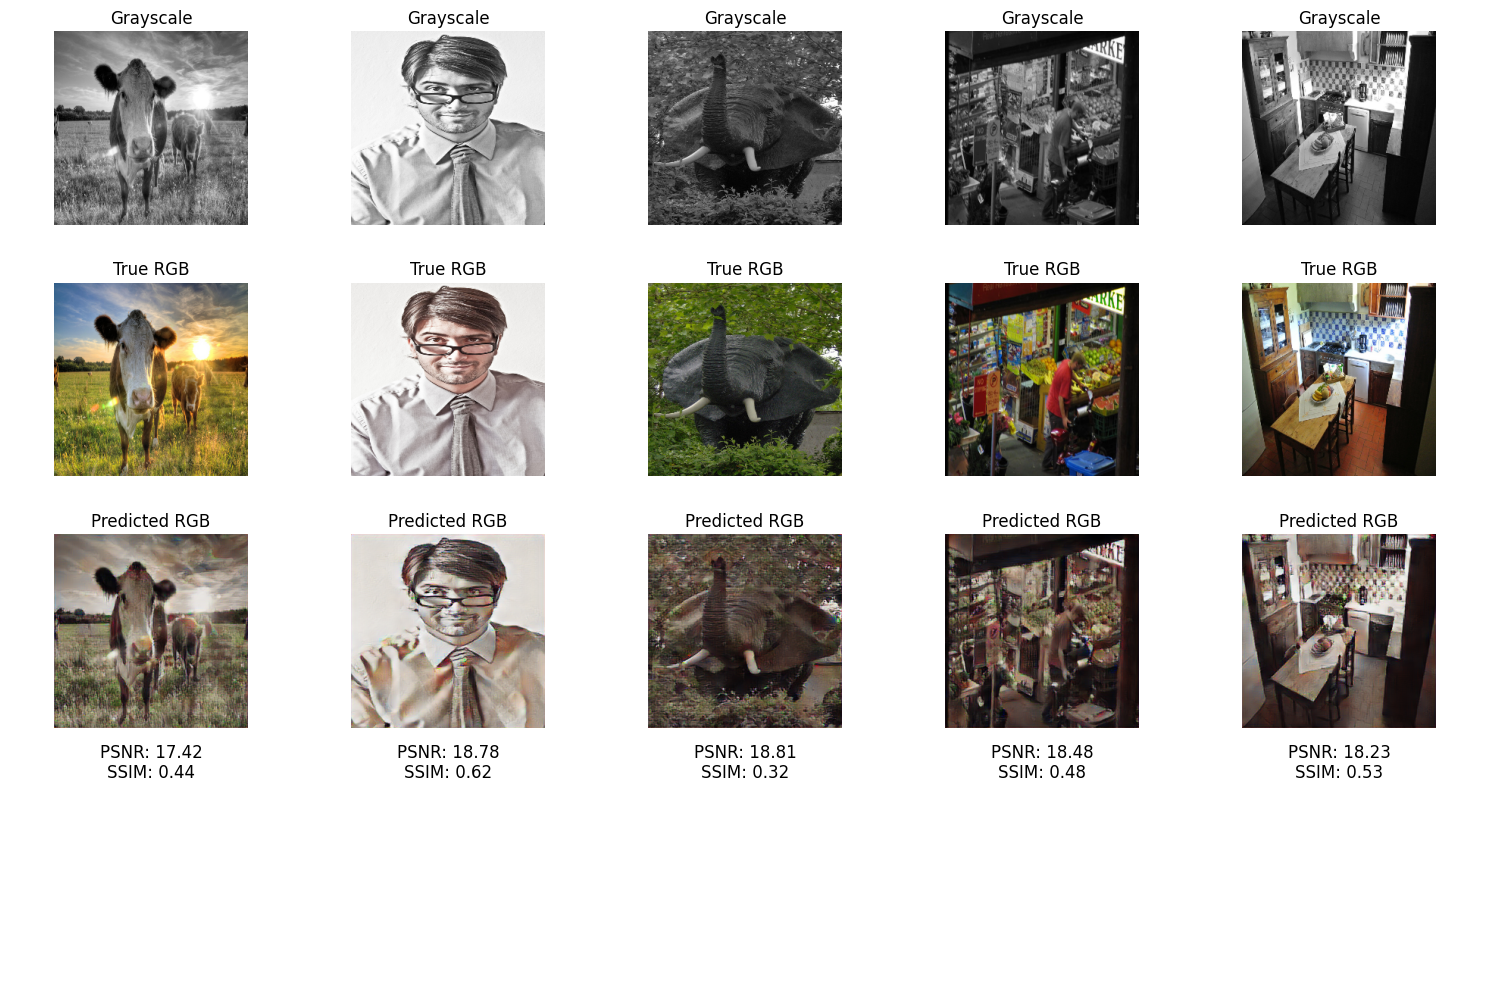

Average PSNR: 18.34
Average SSIM: 0.48


In [179]:
prediction_examples(rgb_model_perceptual, val_dataset)

In [180]:


custom_objects = {
    "psnr": psnr,
    "ssim": ssim,
}

rgb_model_mse = load_model("rgb_model_256x256_75_epochs_mse_10000imgs_benchmark.keras", 
                                  custom_objects = custom_objects)


m_psnr, m_ssim = evaluate_model_on_validation(rgb_model_mse, val_dataset) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Mean PSNR: 21.34 dB
Mean SSIM: 0.7808
Mean MSE: 0.007792
Mean MAE: 0.058867


ValueError: too many values to unpack (expected 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


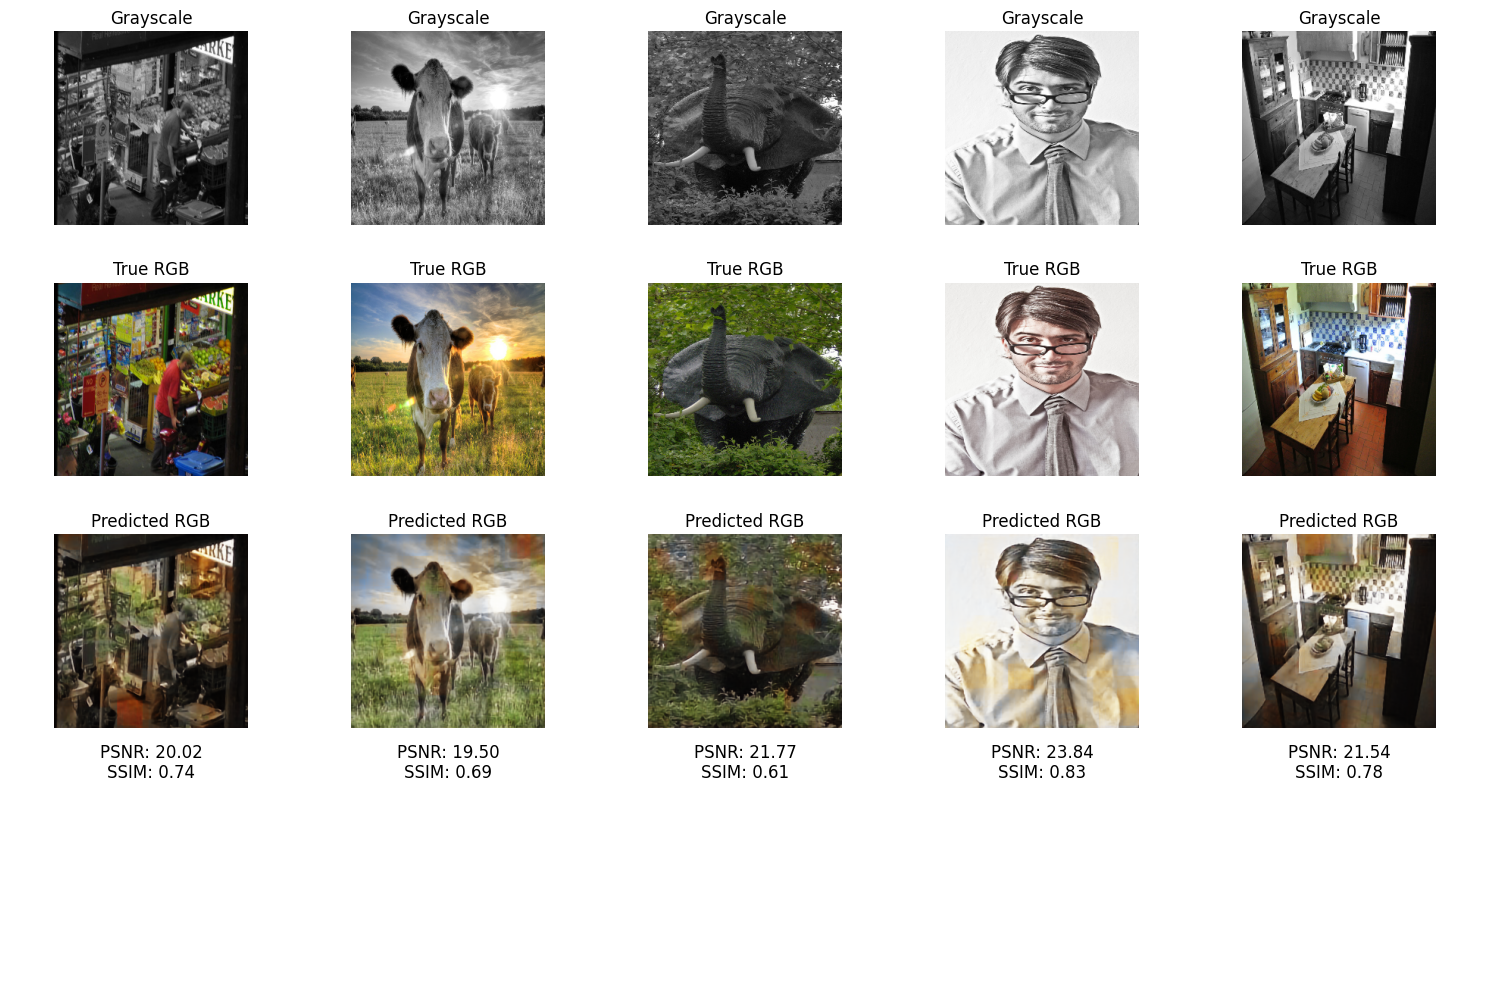

Average PSNR: 21.34
Average SSIM: 0.73


In [182]:
prediction_examples(rgb_model_mse, val_dataset)



RGB_mse:
Mean PSNR: 21.16
Mean SSIM: 0.78

RGB_perceptual: 
Mean PSNR: 18.46
Mean SSIM: 0.57

# Lab models

In [190]:
from pathlib import Path

data_dir = 'coco_dataset/VAL'
# data_dir = 'coco_dataset/test2017_benchmark_10000/'

image_size = (256, 256)
batch_size = 5

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

def preprocess_for_colorization(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(grayscale.shape, image.shape)
    return grayscale/255.0, image/255.0
def preprocess_with_mask(image):
    grayscale = tf.image.rgb_to_grayscale(image)  # (128, 128, 1)
    print(image.shape)
    height, width = image.shape[1], image.shape[2]

    # Create a binary mask with 1% of pixels randomly set to 1
    num_pixels = height * width
    num_hints = int(0.01 * num_pixels) 
    flat_indices = tf.random.shuffle(tf.range(num_pixels))[:num_hints]
    binary_mask = tf.scatter_nd(
        indices=tf.expand_dims(flat_indices, axis=1),
        updates=tf.ones_like(flat_indices, dtype=tf.float32),
        shape=(num_pixels,)
    )
    binary_mask = tf.reshape(binary_mask, (height, width))  # Reshape to 2D

    # Expand binary mask to 3 channels and apply it to the original image
    binary_mask = tf.expand_dims(binary_mask, axis=-1)
    color_mask = image * tf.cast(binary_mask, dtype=image.dtype)

    grayscale = grayscale / 255.0
    color_mask = color_mask / 255.0
    image = image / 255.0
    return (grayscale, color_mask), image


# from skimage.color import rgb2lab, lab2lch
import tensorflow_io
from tensorflow_io.python.experimental.color_ops import rgb_to_lab
def preprocess_lab(image):

    image = tf.cast(image/255, tf.float32)
    lab = rgb_to_lab(image)
    l = lab[...,0]/100.0
    a = ( lab[...,1] + 128.0) /256.0
    b = ( lab[...,2] + 128.0) /256.0
    l = tf.expand_dims(l, axis=-1)
    a = tf.expand_dims(a, axis=-1)
    b = tf.expand_dims(b, axis=-1)
    ab = tf.concat([a,b], axis=-1)
    print(l.shape, ab.shape)
    return l, ab, l

colorization_dataset = dataset.map(preprocess_lab, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# val_size = int(0.2 * len(list(Path(data_dir).glob('*')))) // batch_size
# train_dataset = colorization_dataset.skip(val_size)
# val_dataset = colorization_dataset.take(val_size)

# Ajouter des optimisations (mélange, préchargement)
val_dataset = colorization_dataset.prefetch(tf.data.experimental.AUTOTUNE)
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Function to convert Lab to RGB for visualization
def convert_lab_to_rgb(l_channel, ab_channels):
    """
    Converts L and ab channels into RGB format using skimage's lab2rgb.
    """
    l_channel = (l_channel ) * 100.0  # Scale back to Lab range
    ab_channels = (ab_channels ) * 256.0 - 128 # Scale back to Lab range
    lab = tf.concat([l_channel,ab_channels], axis=-1)
    rgb = tensorflow_io.python.experimental.color_ops.lab_to_rgb(lab)

    return rgb
# Updated function to include SSIM and PSNR metrics
def predict_and_visualize_lab(model, dataset, num_images=5):
    """
    Predicts and visualizes images from the dataset, and computes SSIM and PSNR metrics.
    Args:
        model: Trained colorization model
        dataset: Dataset with grayscale (L channel) inputs
        num_images: Number of images to visualize
    """
    losses = []
    ssim_values = []
    psnr_values = []

    # Take a batch of images
    for batch, ground_truth, l in dataset.take(1):
        # Only take 1 batch for visualization
        l_inputs = batch
        l_inputs = l_inputs[:num_images]  # Limit the number of images
        ground_truth = ground_truth[:num_images]

        # Predict ab channels
        predicted_ab = model.predict(l_inputs)

        # Prepare for visualization and metric calculation
        for i in range(num_images):
            l_channel = l_inputs[i]
            ab_channels_pred = np.array(predicted_ab[i])
            ab_channels_gt = ground_truth[i]

            # Convert to RGB for visualization
            pred_rgb = convert_lab_to_rgb(l_channel, ab_channels_pred)
            img = (np.array(pred_rgb) * 255).astype(np.uint8)  # Convert to 8-bit format
            Image.fromarray(img).save(f"VAL_PRED/LAB_MSE_{i}.png")
            gt_rgb = convert_lab_to_rgb(l_channel, ab_channels_gt)
            # print(pred_rgb)
            # Calculate SSIM and PSNR
            ssim_value = tf.image.ssim(pred_rgb, gt_rgb, max_val=1.0)
            psnr_value = tf.image.psnr(pred_rgb, gt_rgb, max_val=1.0)

            ssim_values.append(ssim_value.numpy())
            psnr_values.append(psnr_value.numpy())

            # Plot images
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 7, 1)
            plt.imshow(l_channel, cmap="gray")
            plt.title("Grayscale (L Channel)")
            plt.axis("off")

            plt.subplot(1, 7, 2)
            plt.imshow(ab_channels_pred[..., 1], cmap="gray")
            plt.title("Predicted b")
            plt.axis("off")

            plt.subplot(1, 7, 3)
            plt.imshow(ab_channels_gt[..., 1], cmap="gray")
            plt.title("Ground Truth b")
            plt.axis("off")

            plt.subplot(1, 7, 4)
            plt.imshow(ab_channels_pred[..., 0], cmap="gray")
            plt.title("Predicted a")
            plt.axis("off")

            plt.subplot(1, 7, 5)
            plt.imshow(ab_channels_gt[..., 0], cmap="gray")
            plt.title("Ground Truth a")
            plt.axis("off")

            plt.subplot(1, 7, 6)
            plt.imshow(pred_rgb)
            plt.title("Predicted RGB")
            plt.axis("off")

            plt.subplot(1, 7, 7)
            plt.imshow(gt_rgb)
            plt.title("Ground Truth RGB")
            plt.axis("off")

            plt.suptitle(f"SSIM: {ssim_value.numpy():.4f}, PSNR: {psnr_value.numpy():.2f} dB", fontsize=16)
            plt.show()

            # Calculate and store MSE losses for visualization
            mse = tf.keras.losses.MeanSquaredError()
            losses.append(mse(ab_channels_gt, ab_channels_pred).numpy())

    # Print average SSIM and PSNR
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")
    print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")

    return losses, ssim_values, psnr_values



Found 5 files.
(None, 256, 256, 1) (None, 256, 256, 2)


In [97]:


custom_objects = {
    "psnr": psnr,
    "ssim": ssim,
}


lab_model_vgg = create_lab_colorization_model_with_vgg_features()
lab_model_vgg.load_weights("lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark.keras")  

 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


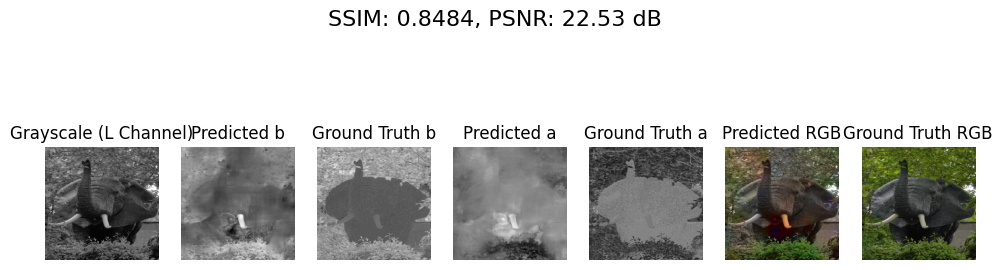

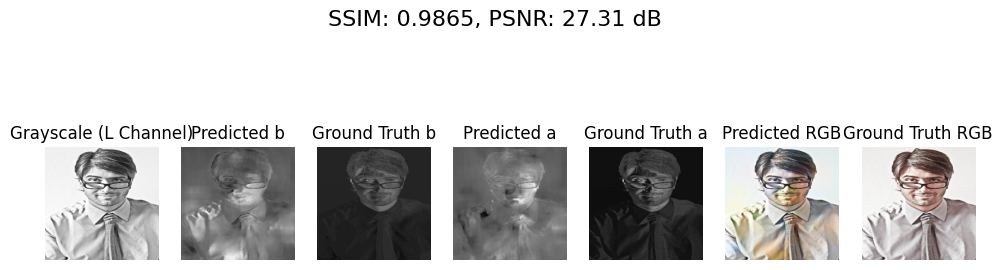

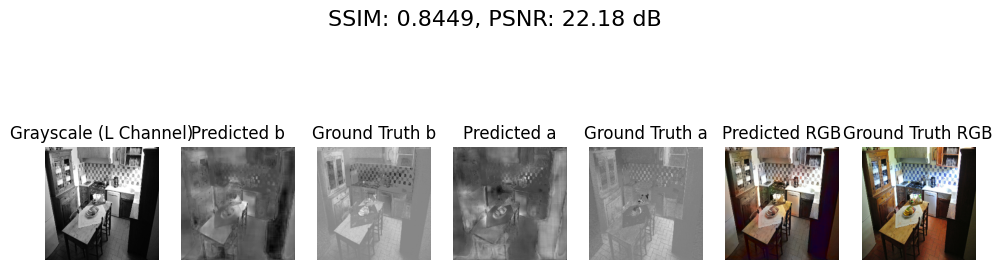

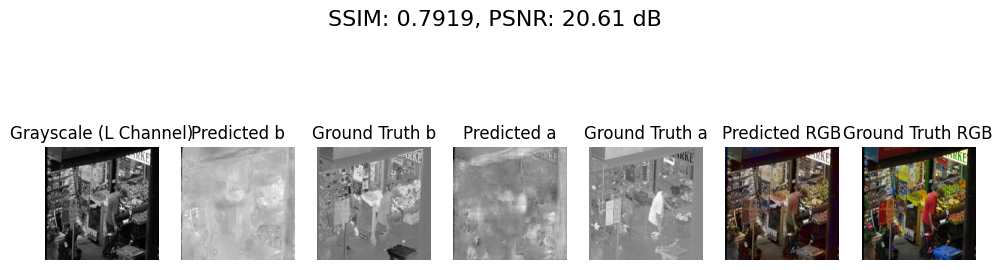

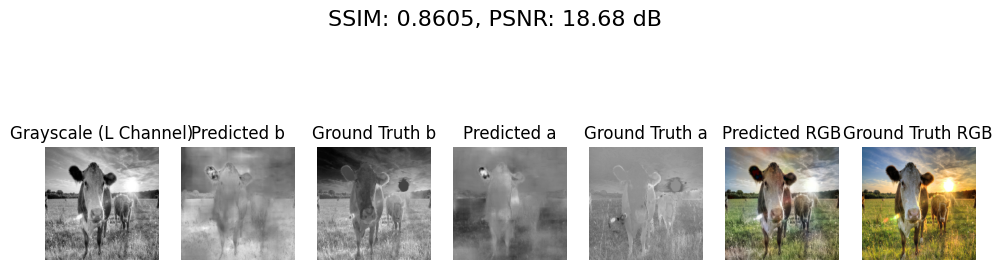

Average SSIM: 0.8665
Average PSNR: 22.26 dB


([0.0028094868, 0.00076803076, 0.0028024875, 0.00396994, 0.005169877],
 [0.84841734, 0.9865222, 0.8449356, 0.7918866, 0.86052704],
 [22.52692, 27.310719, 22.18254, 20.613869, 18.680542])

In [189]:
predict_and_visualize_lab(lab_model_vgg, val_dataset)

In [105]:

# Updated function to include SSIM, PSNR, MSE, and MAE metrics
def evaluate_vgg(model, dataset):

    mses = []
    maes = []
    ssim_values = []
    psnr_values = []

    # Iterate over the entire dataset
    for batch, ground_truth, l in dataset:
        # No need to limit images per batch; process all images in the batch
        l_inputs = batch
        ground_truth = ground_truth

        # Predict ab channels
        predicted_ab = model.predict(l_inputs)

        # Initialize loss functions
        mse_loss_fn = tf.keras.losses.MeanSquaredError()
        mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

        # Prepare for metric calculation
        for i in range(len(l_inputs)):  # Iterate over the full batch size (all images in the batch)
            l_channel = l_inputs[i]
            ab_channels_pred = np.array(predicted_ab[i])
            ab_channels_gt = ground_truth[i]

            # Convert to RGB for visualization
            pred_rgb = convert_lab_to_rgb(l_channel, ab_channels_pred)
            gt_rgb = convert_lab_to_rgb(l_channel, ab_channels_gt)

            # Calculate SSIM and PSNR
            ssim_value = tf.image.ssim(pred_rgb, gt_rgb, max_val=1.0)
            psnr_value = tf.image.psnr(pred_rgb, gt_rgb, max_val=1.0)
            ssim_values.append(ssim_value.numpy())
            psnr_values.append(psnr_value.numpy())

            # Calculate MSE and MAE
            mse_value = mse_loss_fn(gt_rgb, pred_rgb).numpy()
            mae_value = mae_loss_fn(gt_rgb, pred_rgb).numpy()
            mses.append(mse_value)
            maes.append(mae_value)

    # Print average SSIM, PSNR, MSE, and MAE for the entire dataset
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")
    print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
    print(f"Average MSE: {np.mean(mses):.6f}")
    print(f"Average MAE: {np.mean(maes):.6f}")

    return mses, maes, ssim_values, psnr_values


In [106]:
evaluate_vgg(lab_model_vgg, val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


W0000 00:00:1734464605.551680  280096 assert_op.cc:38] Ignoring Assert operator Lab_Colorization_Model_With_VGG_Features_1/Pseudo_RGB_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1734464605.551849  280096 assert_op.cc:38] Ignoring Assert operator Lab_Colorization_Model_With_VGG_Features_1/Pseudo_RGB_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Average SSIM: 0.8949
Average PSNR: 22.95 dB
Average MSE: 0.006328
Average MAE: 0.050455


2024-12-17 20:43:28.329254: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


([0.0022939553,
  0.0027371966,
  0.016507333,
  0.014684312,
  0.012731903,
  0.0019941935,
  0.0028125662,
  0.0043857787,
  0.003247105,
  0.0053397873,
  0.005757938,
  0.0069973236,
  0.0053946977,
  0.0031113222,
  0.018836442,
  0.0016122655,
  0.0027239714,
  0.0015508841,
  0.008574222,
  0.005121888,
  0.007118948,
  0.0042474344,
  0.0051830104,
  0.006319355,
  0.012425557,
  0.008681864,
  0.0072448533,
  0.0024421792,
  0.004255633,
  0.008689252,
  0.0032748806,
  0.005153721,
  0.0038987435,
  0.008713715,
  0.0039998135,
  0.005180101,
  0.0073731528,
  0.004118042,
  0.006744895,
  0.0020875286,
  0.0036193712,
  0.010459406,
  0.0024027906,
  0.014898089,
  0.002779878,
  0.0020334898,
  0.008090968,
  0.004690068,
  0.0034360029,
  0.0033125123,
  0.011003602,
  0.0048935907,
  0.0060632946,
  0.0024964246,
  0.004557244,
  0.0056144744,
  0.0031657629,
  0.013679387,
  0.0060498663,
  0.0030273208,
  0.0014199974,
  0.0070555154,
  0.0135502,
  0.0059435945,
  0.00

In [157]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def evaluate_lab_mse(model, dataset, num_images=None):
    """
    Evaluates the model on the entire dataset, computes MSE, MAE, SSIM, and PSNR metrics.
    
    Args:
        model: Trained colorization model
        dataset: Dataset with grayscale (L channel) inputs
        num_images: Number of images to evaluate (if None, evaluates the entire dataset)
        
    Returns:
        losses, ssim_values, psnr_values, mae_values: Lists of metrics over all images in the dataset.
    """
    mse_metric = tf.keras.losses.MeanSquaredError()
    mae_metric = tf.keras.losses.MeanAbsoluteError()
    
    losses = []
    ssim_values = []
    psnr_values = []
    mae_values = []
    
    # Iterate over the entire dataset
    for batch, ground_truth, l in dataset:
        l_inputs = batch
        if num_images:
            l_inputs = l_inputs[:num_images]  # Limit the number of images
            ground_truth = ground_truth[:num_images]

        # Predict ab channels
        predicted_ab = model.predict(l_inputs)

        # Calculate metrics for each image in the batch
        for i in range(l_inputs.shape[0]):
            l_channel = l_inputs[i]
            ab_channels_pred = np.array(predicted_ab[i])
            ab_channels_gt = ground_truth[i]

            # Convert to RGB for visualization
            pred_rgb = convert_lab_to_rgb(l_channel, ab_channels_pred)
            gt_rgb = convert_lab_to_rgb(l_channel, ab_channels_gt)

            # Calculate SSIM and PSNR
            ssim_value = tf.image.ssim(pred_rgb, gt_rgb, max_val=1.0)
            psnr_value = tf.image.psnr(pred_rgb, gt_rgb, max_val=1.0)
            
            ssim_values.append(ssim_value.numpy())
            psnr_values.append(psnr_value.numpy())

            # Calculate MSE and MAE
            mse_value = mse_metric(ab_channels_gt, ab_channels_pred).numpy()
            mae_value = mae_metric(ab_channels_gt, ab_channels_pred).numpy()

            losses.append(mse_value)
            mae_values.append(mae_value)

    # Print average SSIM, PSNR, MSE, and MAE
    print(f"Average SSIM: {np.mean(ssim_values):.4f}")
    print(f"Average PSNR: {np.mean(psnr_values):.2f} dB")
    print(f"Average MSE: {np.mean(losses):.6f}")
    print(f"Average MAE: {np.mean(mae_values):.6f}")

    return losses, ssim_values, psnr_values, mae_values


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


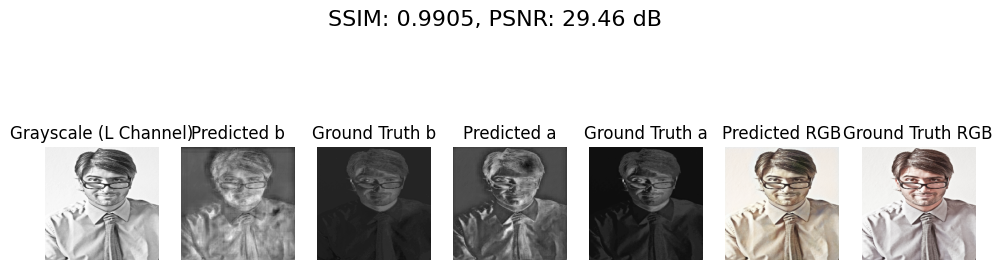

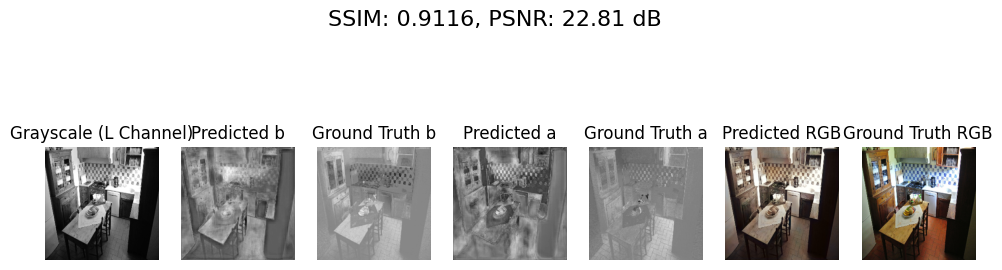

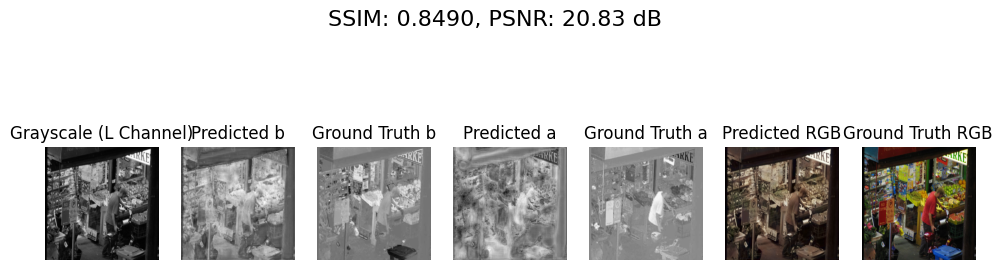

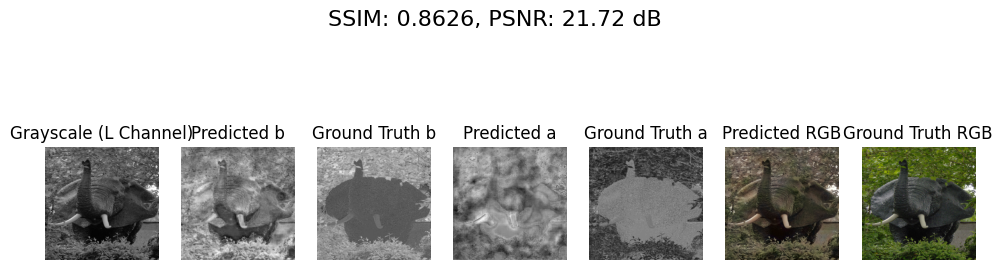

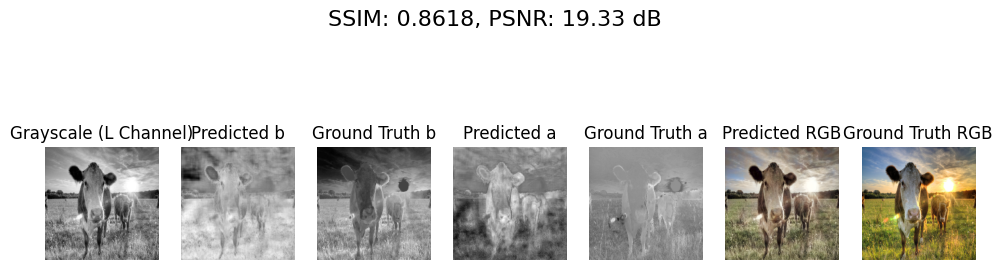

Average SSIM: 0.8951
Average PSNR: 22.83 dB


([0.0004899054, 0.0022562218, 0.0036190182, 0.003520098, 0.0045262584],
 [0.9905322, 0.91156626, 0.8489816, 0.8625679, 0.8617892],
 [29.462374, 22.812227, 20.828064, 21.718674, 19.32618])

In [191]:
predict_and_visualize_lab(lab_model_mse, val_dataset)

In [158]:


custom_objects = {
    "psnr": psnr,
    "ssim": ssim,
}

lab_model_mse = load_model("lab_model_256x256_75_epochs_mse_10000imgs_benchmark.keras", 
                                  custom_objects = custom_objects)

m_psnr, m_ssim = evaluate_lab_mse(lab_model_mse, val_dataset) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Average SSIM: 0.9101
Average PSNR: 22.86 dB
Average MSE: 0.002656
Average MAE: 0.035704


ValueError: too many values to unpack (expected 2)

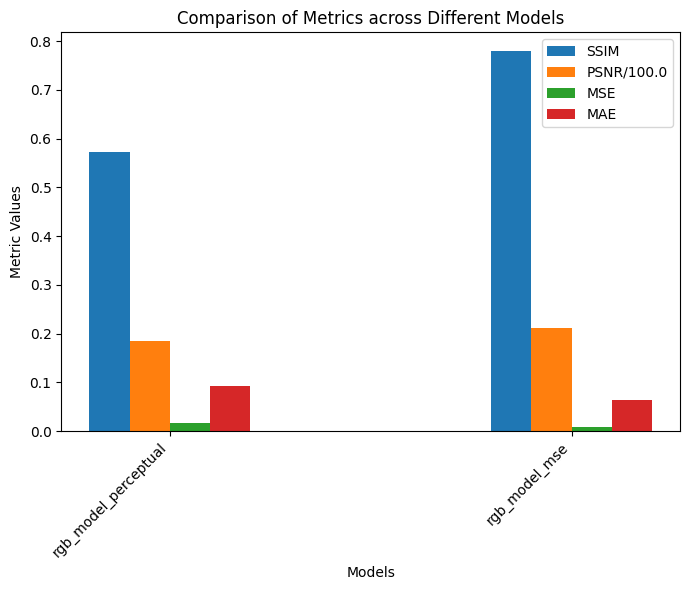

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each model: (SSIM, PSNR, MSE, MAE)
models = [
    "rgb_model_perceptual",
    "rgb_model_mse",
    # "lab_vgg16",
    # "lab_mse",
    # "rgb_GAN_base",
    # "rgb_GAN_2_disc"
]

#  lab mse
# Average SSIM: 0.9101
# Average PSNR: 22.86 dB
# Average MSE: 0.002656
# Average MAE: 0.035704

# ssim_values = [0.5724, 0.7789, 0.8949, 0.9101, 0.8368, 0.7401]
# psnr_values = np.array([18.46, 21.16, 22.95, 22.86, 21.31, 20.52]) / 100.0
# mse_values = np.array([0.015657, 0.008531, 0.006328, 0.002656, 0.0079, 0.0091])
# mae_values =  np.array([0.091695, 0.063269, 0.050455, 0.035704, 0.0551, 0.0670])


ssim_values = [0.5724, 0.7789,  ]
psnr_values = np.array([18.46, 21.16 ]) / 100.0
mse_values = np.array([0.015657, 0.008531, ])
mae_values =  np.array([0.091695, 0.063269 ])

# Plotting the histogram
fig, ax = plt.subplots(figsize=(7, 6))

bar_width = 0.1  # Width of the bars
index = np.arange(len(models))  # Position of the bars on the x-axis

# Creating bars for each metric
bar1 = ax.bar(index - 1.5 * bar_width, ssim_values, bar_width, label="SSIM")
bar2 = ax.bar(index - 0.5 * bar_width, psnr_values, bar_width, label="PSNR/100.0")
bar3 = ax.bar(index + 0.5 * bar_width, mse_values, bar_width, label="MSE")
bar4 = ax.bar(index + 1.5 * bar_width, mae_values, bar_width, label="MAE")

# Adding labels and title
ax.set_xlabel("Models")
ax.set_ylabel("Metric Values")
ax.set_title("Comparison of Metrics across Different Models")
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


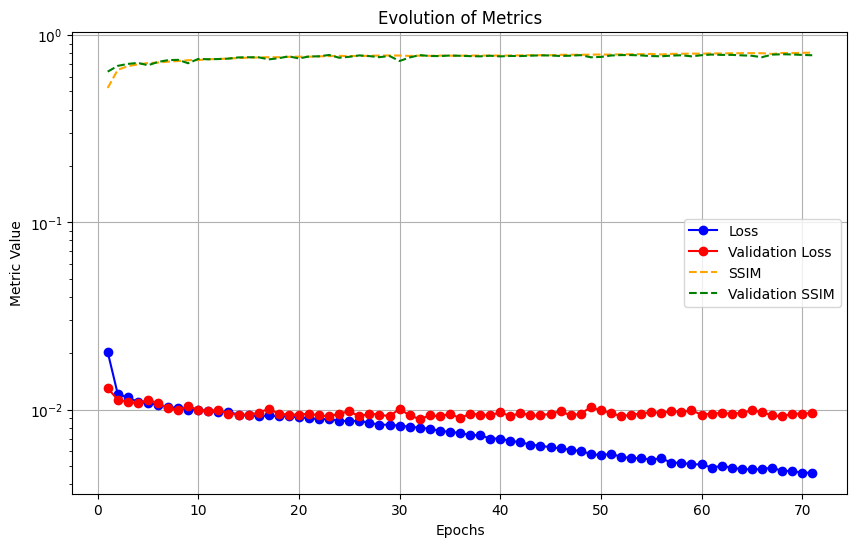

In [135]:
import json
import matplotlib.pyplot as plt

# Fonction pour lire le fichier JSON et extraire les données
def load_metrics_from_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

# Fonction pour tracer l'évolution des métriques
def plot_metrics(data):
    epochs = range(1, len(data['loss']) + 1)

    # Création de la figure et des axes pour afficher les courbes
    plt.figure(figsize=(10, 6))

    # Tracer la courbe de la loss
    plt.semilogy(epochs, data['loss'], label='Loss', color='blue', linestyle='-', marker='o')
    # Tracer la courbe de la val_loss
    plt.semilogy(epochs, data['val_loss'], label='Validation Loss', color='red', linestyle='-', marker = "o")
    # Tracer la courbe du val_mae
    plt.semilogy(epochs, data['ssim'], label='SSIM', color='orange', linestyle='--')
    plt.semilogy(epochs, data['val_ssim'], label='Validation SSIM', color='green', linestyle='--')

    # Ajouter des labels et un titre
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.title('Evolution of Metrics')

    # Ajouter une légende
    plt.legend()

    # Afficher la grille
    plt.grid(True)

    # Afficher le graphique
    plt.show()

# Remplacez par le chemin vers votre fichier JSON
json_file = 'rgb_model_256x256_75_epochs_mse_10000imgs_benchmark_loss.json'  # Mettez ici le chemin de votre fichier JSON

# Charger les données du fichier JSON
metrics_data = load_metrics_from_json(json_file)

# Afficher l'évolution des métriques
plot_metrics(metrics_data)



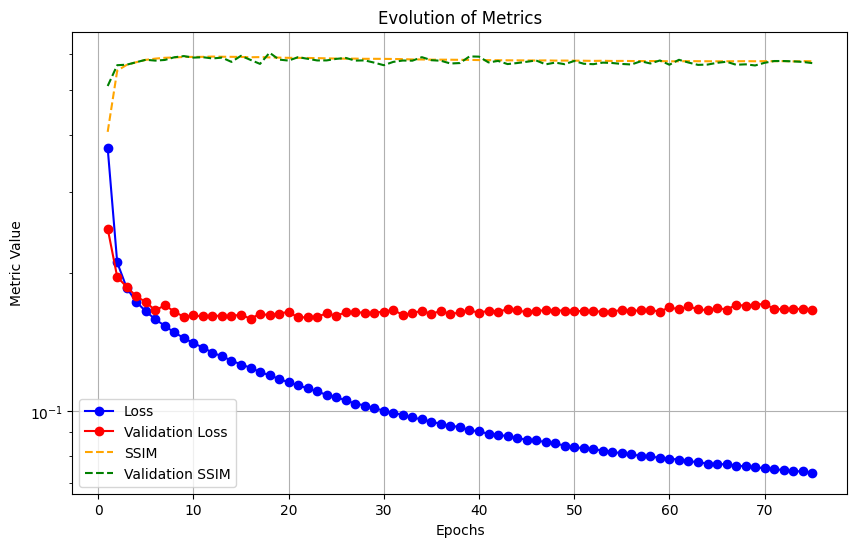

In [136]:
# Remplacez par le chemin vers votre fichier JSON
json_file = 'rgb_model_256x256_75_epochs_perceptual_10000imgs_benchmark_loss.json'  # Mettez ici le chemin de votre fichier JSON

# Charger les données du fichier JSON
metrics_data = load_metrics_from_json(json_file)

# Afficher l'évolution des métriques
plot_metrics(metrics_data)

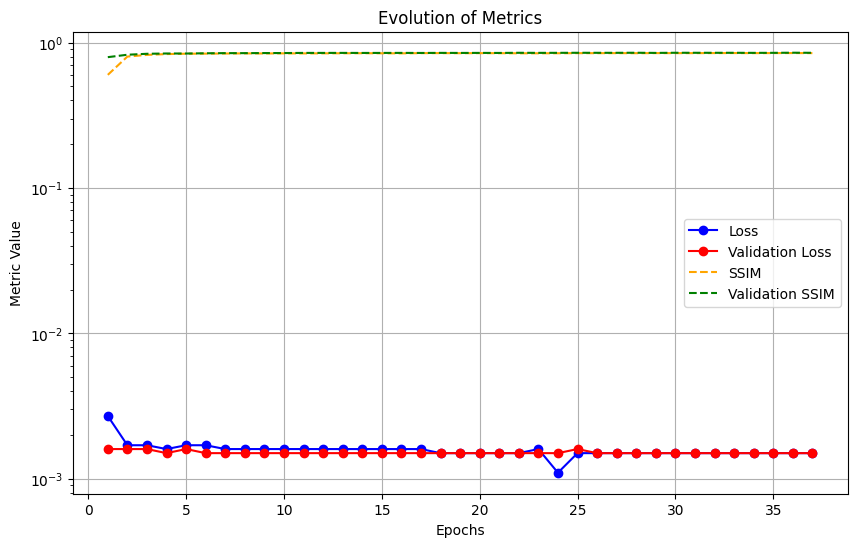

In [137]:
# Remplacez par le chemin vers votre fichier JSON
json_file = 'lab_model_256x256_75_epochs_mse_10000imgs_benchmark_loss.json'  # Mettez ici le chemin de votre fichier JSON

# Charger les données du fichier JSON
metrics_data = load_metrics_from_json(json_file)

# Afficher l'évolution des métriques
plot_metrics(metrics_data)

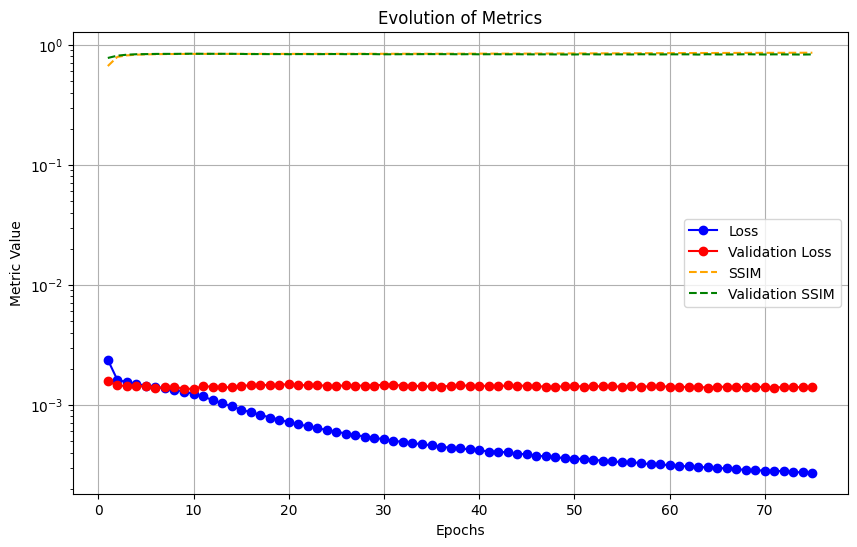

In [140]:
# Remplacez par le chemin vers votre fichier JSON
json_file = 'lab_vgg16_model_256x256_75_epochs_mse_10000imgs_benchmark_loss.json'  # Mettez ici le chemin de votre fichier JSON

# Charger les données du fichier JSON
metrics_data = load_metrics_from_json(json_file)

# Afficher l'évolution des métriques
plot_metrics(metrics_data)